In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sys
import pickle
import matplotlib.pyplot as plt


% matplotlib inline

print('Python version', sys.version)
print('Pandas version', pd.__version__)
print('Numpy version', np.__version__)

Python version 3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version 0.20.3
Numpy version 1.14.0


# Import test data

### Import base features

In [3]:
base_features = pd.read_pickle('../data/processed/base_features.pkl')
base_features = base_features.drop(['tweet_id'], axis=1)

base_target = base_features.pop('target')

base_x_train, base_x_test, base_y_train, base_y_test = train_test_split(base_features, base_target,
                                                                    test_size=.2,
                                                                    random_state=42)

### Import text features and target values

In [4]:
text_test = pd.read_pickle('../data/processed/test_text_features.pkl')

# We can use the same target array for both the base and text test sets 
# because our features were split with the same seed
target = text_test.pop('target')
test_target = np.array([int(i) for i in target])

# Evaluate Model

In [5]:
# Generate a confusion matrix plot
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
def evaluate_ensemble(X_base_test, X_text_test, y_test, base_model, text_model):
    
    
    base_predict = base_model.predict_proba(X_base_test)[:,1] 
    text_predict = text_model.predict_proba(X_text_test)[:,1] 
        
    y_score = [np.mean(e) for e in zip(*[base_predict, text_predict])]
    y_class = [1 if y >=.5 else 0 for y in y_score]
    
    # Confusion Matrix
    conf = confusion_matrix(y_test, y_class)
    print ('\n')
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[1, 1] / (conf[0, 1] + conf[1, 1])))
    print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 0] + conf[1, 1])))

    cm = confusion_matrix(y_test, y_class, labels=None)
    # plot the confusion matrix

    print ('\n')
    plt.figure(figsize=(6, 6))
    plot_confusion_matrix(cm)
    plt.show()
 
    
    plt.figure(0, figsize=(6, 6))
    
    # Base Model
    fpr, tpr, thresh = roc_curve(y_test, base_predict)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, color='steelblue', linewidth=3, label="Base="+str(round(roc_auc, 2)))
    print('Base Model: ', roc_auc)

    # Text Model
    fpr, tpr, thresh = roc_curve(y_test, text_predict)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, color='purple', alpha=.7, linewidth=3, label="Text="+str(round(roc_auc, 2)))
    print('Text Model: ', roc_auc)
    
        # Ensembled Model
    fpr, tpr, thresh = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot([0,1],[0,1], linestyle=":", color='grey', linewidth=4) # this is our baseline
    plt.plot(fpr,tpr, color='darkorange', linewidth=3, label="Ensembled="+str(round(roc_auc, 2)))
    plt.xlabel('FPR', fontsize=20)
    plt.ylabel('TPR', fontsize=20)
    print('Ensembled AUC: ', roc_auc)

    plt.legend(loc=0)
    


In [11]:
with open("../models/gcb_trained_base_clf.pkl", "rb") as mdl:
    base_model = pickle.load(mdl)

In [12]:
with open("../models/nb_trained_text_clf.pkl", "rb") as mdl:
    text_model = pickle.load(mdl)



[[3340  715]
 [ 635 2591]]


Precision:              0.78
Recall:                 0.80




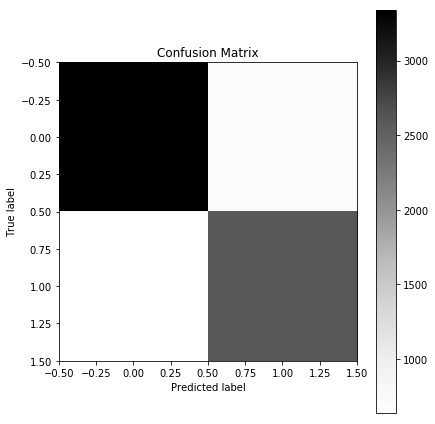

Base Model:  0.8164920043145132
Text Model:  0.8550337004440645
Ensembled AUC:  0.8954930768272276


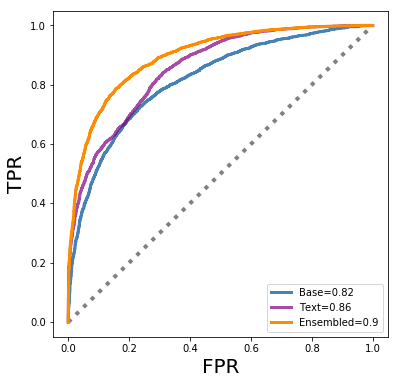

In [13]:
evaluate_ensemble(X_base_test=base_x_test, 
                  X_text_test=text_test, 
                  y_test=test_target, 
                  base_model=base_model, 
                  text_model=text_model)

# Fit classifiers on all data and pickle

## Fit text clf on all tweet data

In [86]:
text_features = pd.read_pickle('../data/processed/all_text_features.pkl')

In [87]:
text_target = pd.read_pickle('../data/processed/all_target.pkl')
text_target = np.array(text_target)

In [88]:
text_model_fit = text_model.fit(text_features, text_target)

In [89]:
with open('../models/final_text_clf.pkl', 'wb') as file:
    pickle.dump(text_model_fit, file)

## Fit base clf on all base data

In [90]:
base_model_fit = base_model.fit(base_features, base_target)

In [91]:
with open('../models/final_base_clf.pkl', 'wb') as file:
    pickle.dump(base_model_fit, file)